In [1]:
# %pip install seaborn
# %pip install opencv-python
# %pip install timer

In [2]:
import pyNN.spiNNaker as p
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from mpl_toolkits.axes_grid1 import ImageGrid
import pyNN.utility.plotting as plot
import numpy as np
import seaborn as sns
import os
import sys
import random
%matplotlib inline

# Printing max length of array that can be created
print(sys.maxsize)

# Importing functions for NMNIST Data
import eventvision as ev

# Setting up simulation
p.setup(timestep=1,time_scale_factor=10)
# p.set_number_of_neurons_per_core(neuron_type=p.IF_cond_exp(),max_permitted=150)

Detected PyNN version 0.9.4 and Neo version 0.6.1
9223372036854775807


2020-03-31 00:41:29 INFO: Read cfg files: /home/jovyan/sPyNNaker/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/jovyan/sPyNNaker/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/jovyan/.spynnaker.cfg
2020-03-31 00:41:29 INFO: Will search these locations for binaries: /home/jovyan/sPyNNaker/lib/python3.6/site-packages/spinn_front_end_common/common_model_binaries : /home/jovyan/sPyNNaker/lib/python3.6/site-packages/spynnaker/pyNN/model_binaries
2020-03-31 00:41:29 INFO: Setting time scale factor to 10.
2020-03-31 00:41:29 INFO: Setting machine time step to 1000 micro-seconds.


Event-based vision module imported
['/home/jovyan/sPyNNaker/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jovyan/sPyNNaker/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jovyan/.spynnaker.cfg']


0

In [3]:
# Important Variables
n_excitatory_neurons = 100
excitatory_neuron_parameters = {
    'v_rest':   -65.0,  # Resting membrane potential in mV.
    'cm':         1.0,  # Capacity of the membrane in nF
    'tau_m':     100.0,  # Membrane time constant in ms.
    'tau_refrac': 5.0,  # Duration of refractory period in ms.
    'tau_syn_E':  1.0,  # Decay time of the excitatory synaptic conductance in ms.
    'tau_syn_I':  2.0,  # Decay time of the inhibitory synaptic conductance in ms.
    'e_rev_E':    0.0,  # Reversal potential for excitatory input in mV
    'e_rev_I':  -100.0,  # Reversal potential for inhibitory input in mV
    'v_thresh': -52.0,  # Spike threshold in mV.
    'v_reset':  -65.0,  # Reset potential after a spike in mV.
    'i_offset':   0.0,  # Offset current in nA
}
n_inhibitory_neurons = n_excitatory_neurons
inhibitory_neuron_parameters = {
    'v_rest':   -60.0,  # Resting membrane potential in mV.
    'cm':         1.0,  # Capacity of the membrane in nF
    'tau_m':     10.0,  # Membrane time constant in ms.
    'tau_refrac': 2.0,  # Duration of refractory period in ms.
    'tau_syn_E':  1.0,  # Decay time of the excitatory synaptic conductance in ms.
    'tau_syn_I':  2.0,  # Decay time of the inhibitory synaptic conductance in ms.
    'e_rev_E':    0.0,  # Reversal potential for excitatory input in mV
    'e_rev_I':  -85.0,  # Reversal potential for inhibitory input in mV
    'v_thresh': -40.0,  # Spike threshold in mV.
    'v_reset':  -45.0,  # Reset potential after a spike in mV.
    'i_offset':   0.0,  # Offset current in nA
}

# Data

In [4]:
training_data_lists = [os.listdir(os.getcwd()+"/data/train/"+str(i)+"/") for i in range(10)]
training_class_lens = [len(i) for i in training_data_lists]
num_classes = 3 # Number of Classes
# classes = [i for i in range(num_classes)]
classes = [5,6,9] # i.e. digits 5,6,9
time_per_exp = 750 # Time in ms per example
num_examples_seen = {c:0 for c in classes}
batch_size = 10
# Simulation for batch_size*10 examples will be done together
total_examples = sum(training_class_lens)
class_history = []

Class is 6
305842


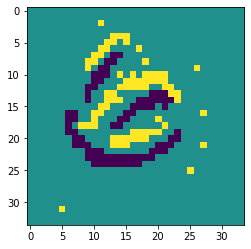

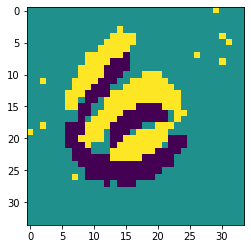

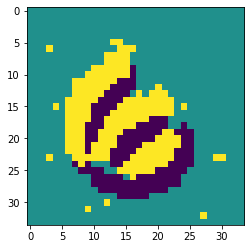

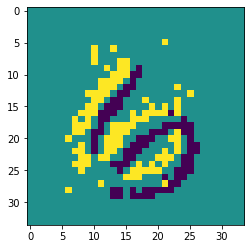

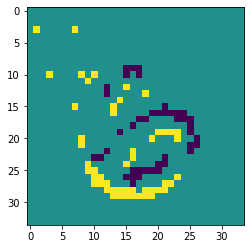

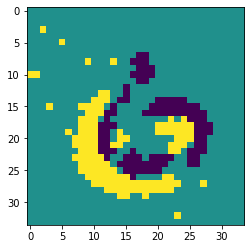

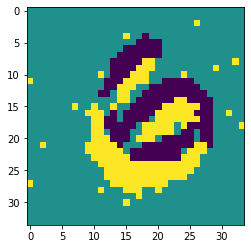

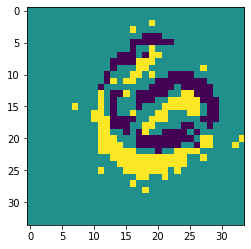

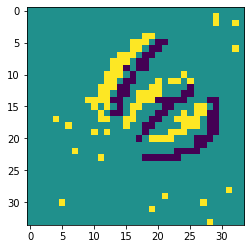

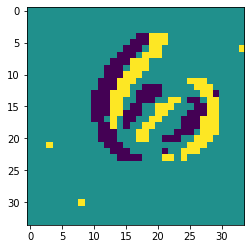

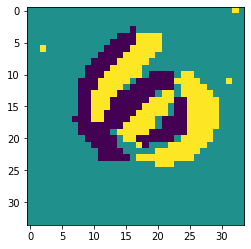

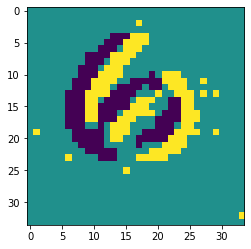

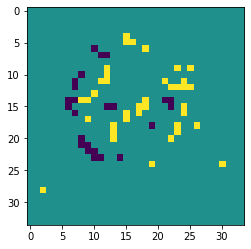

In [5]:
# Displaying a random example
classs = np.random.randint(low=0,high=num_classes)
classs = classes[classs]
num_exp = np.random.randint(low=0,high=training_class_lens[classs])
print("Class is "+str(classs))
disp_exp = ev.read_dataset(os.getcwd()+"/data/train/"+str(classs)+"/"+str(training_data_lists[classs][num_exp]))
print(disp_exp.data.ts[-1])
disp_exp.show_td(frame_length=24e3)

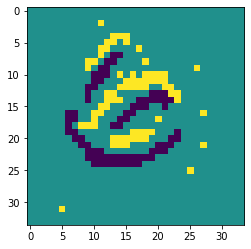

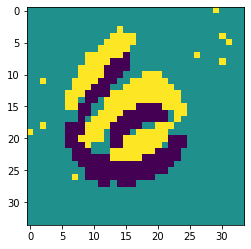

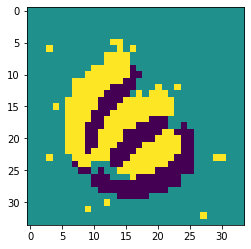

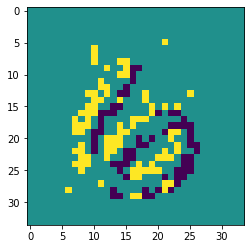

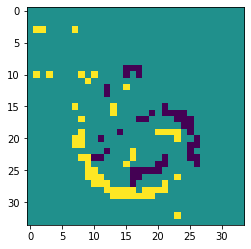

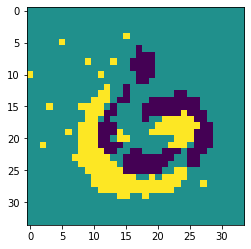

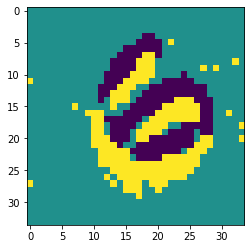

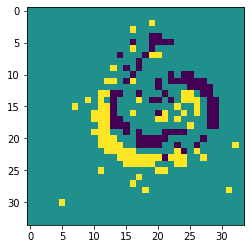

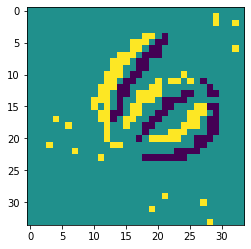

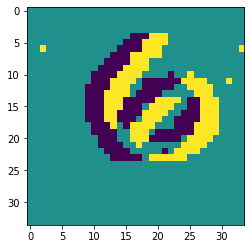

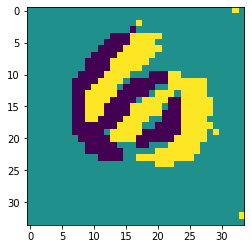

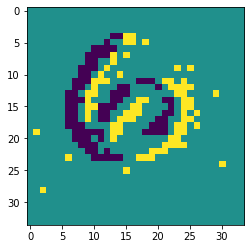

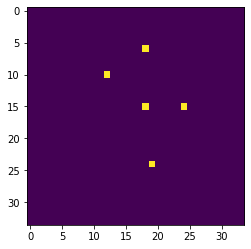

In [6]:
#Scaled down data
for i in range(len(disp_exp.data.ts)):
    disp_exp.data.ts[i]=disp_exp.data.ts[i]//1000
disp_exp.show_td(frame_length=24)

In [7]:
# Maximum spike time is 315474 micro seconds (number 6)
# Random Class selector
# class_selector = np.random.randint(low=0,high=num_classes,size=batch_size*num_classes)
class_selector = []
for i in range(batch_size):
    random.shuffle(classes)
    class_selector+=classes
class_history+=list(class_selector)
spike_array = [[] for _ in range(34*34)]
for classs in class_selector:
    data_point = ev.read_dataset(os.getcwd()+"/data/train/"+str(classs)+"/"+str(training_data_lists[classs][num_examples_seen[classs]]))
    data_point_spike_array = [[] for _ in range(34*34)]
    for d in range(len(data_point.data.x)):
        if data_point.data.p[d]: # Polarity = ON
            data_point_spike_array[data_point.data.x[d]*34+data_point.data.y[d]].append(data_point.data.ts[d]//1000+time_per_exp*sum(num_examples_seen.values())+50)# Plus 50 as first 50 mseconds is just to simulate start spike
    num_examples_seen[classs]+=1
    idx_sa = 0
    for sa,dpsa in zip(spike_array,data_point_spike_array):
        spike_array[idx_sa] = sa+dpsa
        idx_sa+=1
num_events=0
for i in spike_array:
    num_events+=len(i)
print("Number of events is "+str(num_events))

Number of events is 60662


# Network

## Neurons

In [8]:
# input
inp = p.Population(1156,
                   p.SpikeSourceArray(spike_array),
                   label="Input"
                  )
# excitatory
exc = p.Population(n_excitatory_neurons,
                   p.IF_cond_exp(**excitatory_neuron_parameters),
                   initial_values={'v': excitatory_neuron_parameters["v_rest"]},
                   label="Excitatory"
                  )
# inhibitory
inh = p.Population(n_inhibitory_neurons,
                   p.IF_cond_exp(**inhibitory_neuron_parameters),
                   initial_values={'v': inhibitory_neuron_parameters["v_rest"]},
                   label="Inhibitory"
                  )

In [9]:
# Record Spikes
inp.record("spikes") # Testing
exc.record(["spikes",'gsyn_exc', 'gsyn_inh','v'])
inh.record(["spikes",'gsyn_exc', 'gsyn_inh','v'])

## Connections

In [10]:
min_weight = 0
max_weight = 1
# E -> I
# e_i_weight_rand = p.RandomDistribution(distribution='uniform',low=0.0,high=max_weight)
p.Projection(presynaptic_population = exc,
             postsynaptic_population = inh,
             connector = p.OneToOneConnector(),
             synapse_type = p.StaticSynapse(weight=1,delay=1.0),
             receptor_type = 'excitatory'
            )

# I -> E
i_e_connection_list = []
for i in range(n_excitatory_neurons):
    for j in range(n_inhibitory_neurons):
        if not i==j:
            i_e_connection_list.append((i,j))
p.Projection(presynaptic_population = inh,
             postsynaptic_population = exc,
             connector = p.FromListConnector(i_e_connection_list),
             synapse_type = p.StaticSynapse(weight=0.0625,delay=1.0), # 0.0001
             receptor_type = 'inhibitory'
            )

# Input -> E
stdp_initial_weights = p.RandomDistribution(distribution='normal_clipped',low=0,high=1, mu=0.5, sigma=0.3)
print("Testing stdp initial weight random generator, rand value = ",str(stdp_initial_weights.next()))
timing_rule = p.SpikePairRule(tau_plus=8.0,tau_minus=2.0, #8,1
                             A_plus=0.0625,A_minus=0.0625) # 80,20
weight_rule = p.AdditiveWeightDependence(w_max=max_weight,w_min=min_weight)
# weight_rule = p.MultiplicativeWeightDependence(w_min=min_weight, w_max=max_weight)
stdp_model = p.STDPMechanism(timing_dependence=timing_rule,
                            weight_dependence=weight_rule,
                            weight=stdp_initial_weights,delay=1.0)
stdp_proj = p.Projection(presynaptic_population = inp,
             postsynaptic_population = exc,
             connector = p.AllToAllConnector(),
             synapse_type = stdp_model,
             receptor_type = 'excitatory'
            )

Testing stdp initial weight random generator, rand value =  0.023445535341288293


# Simulation

In [11]:
# Printing initial weights
p.run(50)
initial_weights = stdp_proj.get(["weight"],"list", with_address=False)

2020-03-31 00:41:39 INFO: Simulating for 50 1.0ms timesteps using a hardware timestep of 100us
2020-03-31 00:41:39 INFO: Starting execution process
2020-03-31 00:41:46 INFO: Time 0:00:06.227491 taken by SpallocMaxMachineGenerator
Pre allocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2020-03-31 00:42:01 INFO: Time 0:00:15.291808 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2020-03-31 00:42:09 INFO: Time 0:00:07.890204 taken by PartitionAndPlacePartitioner
Created spalloc job 5327631
2020-03-31 00:42:09 INFO: Created spalloc job 5327631
Waiting for board power commands to complete.
2020-03-31 00:42:10 INFO: Waiting for board power commands to complete.
2020-03-31 00:42:18 INFO: Time 0:00:08.943725 taken by SpallocAllocator
2020-03-31 00:

In [12]:
# Simulating
p.run(batch_size*num_classes*time_per_exp)

2020-03-31 00:43:01 INFO: Simulating for 22500 1.0ms timesteps using a hardware timestep of 100us
2020-03-31 00:43:01 INFO: Starting execution process
2020-03-31 00:43:01 INFO: Running for 1 steps for a total of 22500.0ms
2020-03-31 00:43:01 INFO: Run 1 of 1
Generating SDRAM usage report
|0%                          50%                         100%|
2020-03-31 00:43:02 INFO: Time 0:00:00.403721 taken by SdramUsageReportPerChip
clearing IOBUF from the machine
|0%                          50%                         100%|
2020-03-31 00:43:02 INFO: Time 0:00:00.033225 taken by ChipIOBufClearer
Reloading data
|0%                          50%                         100%|
2020-03-31 00:43:02 INFO: Time 0:00:00.053565 taken by DSGRegionReloader
Updating run time
|0%                          50%                         100%|
2020-03-31 00:43:02 INFO: Time 0:00:00.041667 taken by ChipRuntimeUpdater
2020-03-31 00:43:02 INFO: ** Notifying external sources that the database is ready for reading *

22550.0

In [13]:
# Getting Weights and spikes
weights = stdp_proj.get(["weight"],"list", with_address=False)
weights_address = stdp_proj.get(["weight"],"list")
# print(weights)
inp_spikes = inp.get_data("spikes")
# print(inp_spikes.segments[0].spiketrains)
exc_spikes = exc.get_data("spikes")
# print(exc_spikes.segments[0].spiketrains)
inh_spikes = inh.get_data("spikes")
# print(inh_spikes.segments[0].spiketrains)

Getting ['weight']s for projection between Input and Excitatory
|0%                          50%                         100%|
Getting ['source', 'target', 'weight']s for projection between Input and Excitatory
|0%                          50%                         100%|
Getting spikes for Input
|0%                          50%                         100%|
Getting spikes for Excitatory
|0%                          50%                         100%|
Getting spikes for Inhibitory
|0%                          50%                         100%|


In [14]:
exc_v = exc.get_data("v")
exc_ge = exc.get_data('gsyn_exc')
exc_gi = exc.get_data('gsyn_inh')
inh_v = inh.get_data("v")
inh_ge = inh.get_data('gsyn_exc')
inh_gi = inh.get_data('gsyn_inh')

Getting v for Excitatory
|0%                          50%                         100%|
2020-03-31 00:47:05 WARNING: Warning getting data on a whole population when selective recording is active will result in only the requested neurons being returned in numerical order and without repeats.
Getting gsyn_exc for Excitatory
|0%                          50%                         100%|
Getting gsyn_inh for Excitatory
|0%                          50%                         100%|
Getting v for Inhibitory
|0%                          50%                         100%|
Getting gsyn_exc for Inhibitory
|0%                          50%                         100%|
Getting gsyn_inh for Inhibitory
|0%                          50%                         100%|


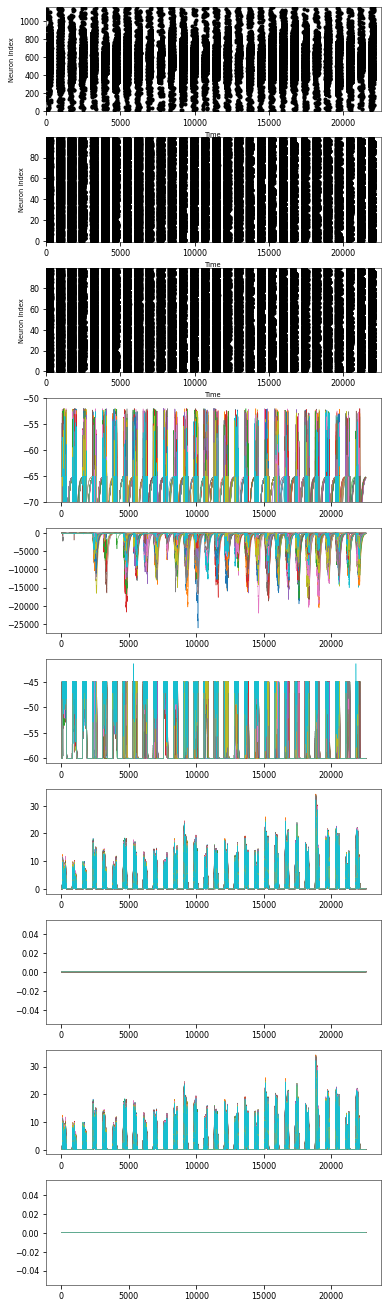

In [15]:
# Plotting spikes
plot.Figure(
    plot.Panel(inp_spikes.segments[0].spiketrains,yticks=True,xticks=True,xlabel="Time"),
    plot.Panel(exc_spikes.segments[0].spiketrains,yticks=True,xticks=True,xlabel="Time"),
    plot.Panel(inh_spikes.segments[0].spiketrains,yticks=True,xticks=True,xlabel="Time"),
    plot.Panel(exc_v.segments[0].filter(name='v')[0],yticks=True,xticks=True,legend=None,ylim=(-70,-50)),
    plot.Panel(exc_v.segments[0].filter(name='v')[0],yticks=True,xticks=True,legend=None),
    plot.Panel(inh_v.segments[0].filter(name='v')[0],yticks=True,xticks=True,legend=None),
    plot.Panel(exc_ge.segments[0].filter(name='gsyn_exc')[0],yticks=True,xticks=True,legend=None),
    plot.Panel(inh_gi.segments[0].filter(name='gsyn_inh')[0],yticks=True,xticks=True,legend=None),
    plot.Panel(exc_ge.segments[0].filter(name='gsyn_exc')[0],yticks=True,xticks=True,legend=None),
    plot.Panel(inh_gi.segments[0].filter(name='gsyn_inh')[0],yticks=True,xticks=True,legend=None)
)

[0.1875 0.5    0.8125 ... 0.375  0.5    0.6875]
3139 out of 115600 are minimum, i.e. w = 0
Minimum Weight is 0.0
3 out of 115600 are maximum, i.e. w = 1
Maximum Weight is 1.0


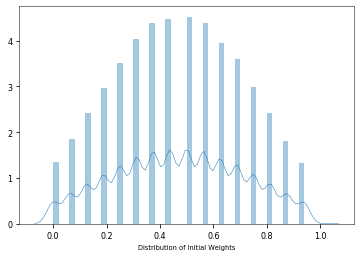

In [16]:
print(initial_weights)
j_min = min_weight
j_max = max_weight
for i in list(initial_weights):
    if i==min_weight:
        j_min+=1
    elif i==max_weight:
        j_max+=1
print(str(j_min)+" out of "+str(len(initial_weights))+" are minimum, i.e. w = "+str(min_weight))
print("Minimum Weight is "+str(min(initial_weights)))
print(str(j_max)+" out of "+str(len(initial_weights))+" are maximum, i.e. w = "+str(max_weight))
print("Maximum Weight is "+str(max(initial_weights)))
plt.figure()
ax = sns.distplot(initial_weights,axlabel="Distribution of Initial Weights")
plt.show()

[0.1875 0.5    0.8125 ... 0.375  0.5    0.6875]
2676 out of 115600 are minimum, i.e. w = 0
Minimum Weight is 0.0
27325 out of 115600 are maximum, i.e. w = 1
Maximum Weight is 1.0


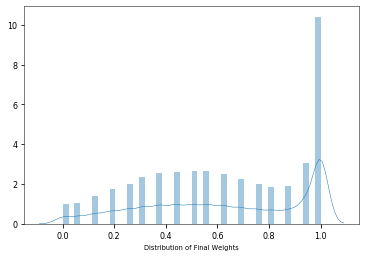

In [17]:
print(weights)
j_min = min_weight
j_max = max_weight
for i in list(weights):
    if i==min_weight:
        j_min+=1
    elif i==max_weight:
        j_max+=1
print(str(j_min)+" out of "+str(len(weights))+" are minimum, i.e. w = "+str(min_weight))
print("Minimum Weight is "+str(min(weights)))
print(str(j_max)+" out of "+str(len(weights))+" are maximum, i.e. w = "+str(max_weight))
print("Maximum Weight is "+str(max(weights)))
plt.figure()
ax = sns.distplot(weights,axlabel="Distribution of Final Weights")
plt.show()

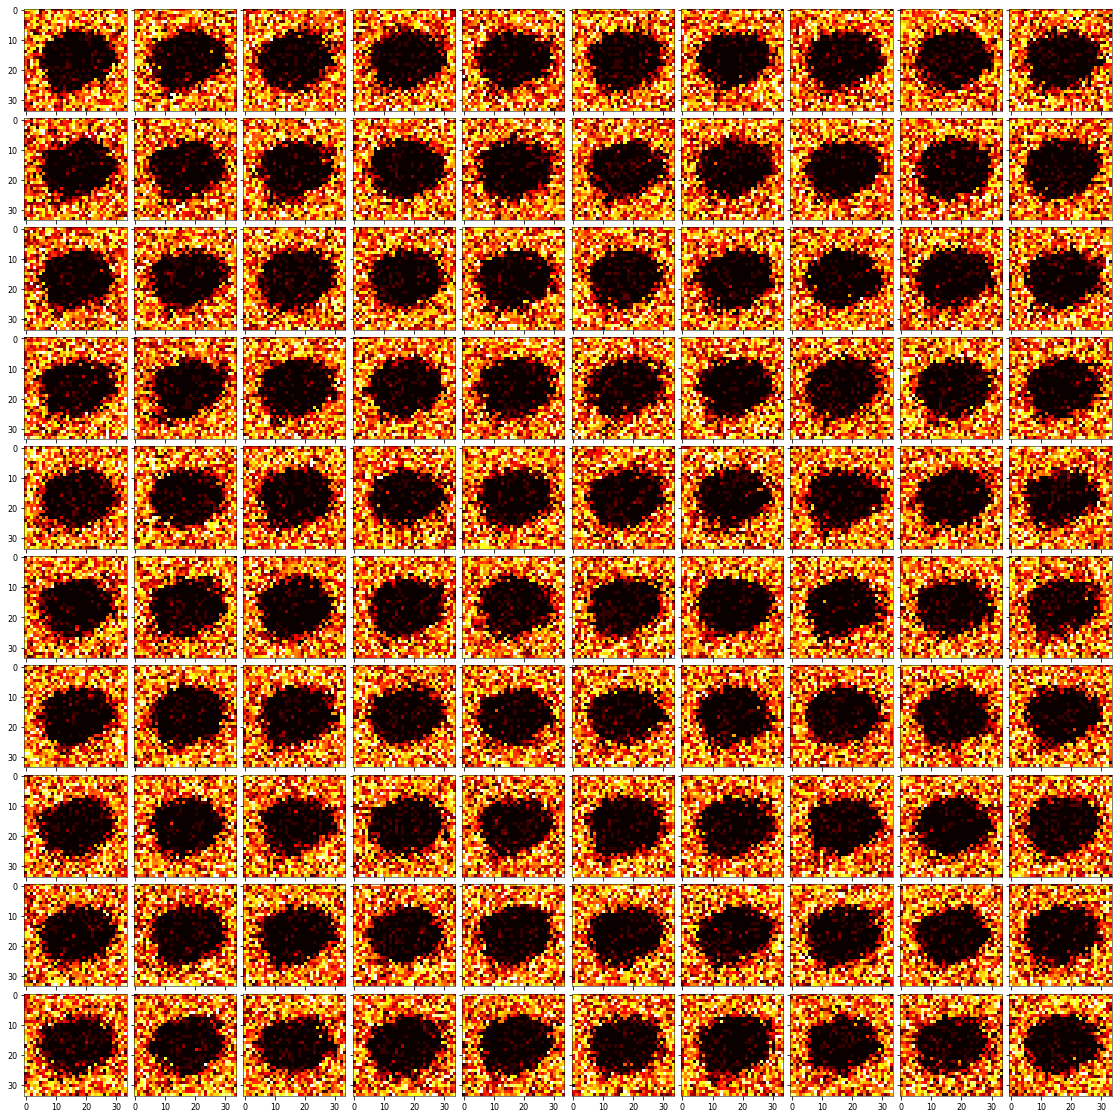

In [18]:
# Visualizing Weights
# 0 1 2 ...
# 10 11 12 ...
# 20 21 22 ...
# ...
# 90 91 92 ...
nRow = int(np.sqrt(n_excitatory_neurons))
nCol = int(np.sqrt(n_excitatory_neurons))
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(nRow, nCol),  # creates nrow x ncol grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
wt_imgs = [np.zeros((34,34),dtype=np.float32) for wt_img in range(n_excitatory_neurons)]
for trgt_nrns in range(n_excitatory_neurons):
    for tp in weights_address: # format of tuple ['source','target','weight']
        if tp[1]==trgt_nrns:
            wt_imgs[trgt_nrns][tp[0]//34][tp[0]%34] = ((tp[2]-min_weight)/max_weight)*255
    
for ax, im in zip(grid, wt_imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap=cmap.get_cmap('hot_r'))
plt.show()

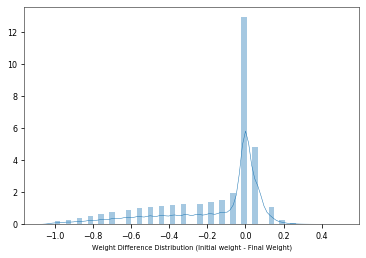

In [19]:
w_diff = [i - j for i,j in zip(initial_weights,weights)]
# plt.figure()
# plt.hist(w_diff)
# plt.show()
plt.figure()
ax = sns.distplot(w_diff,axlabel="Weight Difference Distribution (Initial weight - Final Weight)")
plt.show()

In [20]:
# p.reset()
p.end()

2020-03-31 00:48:49 WARNING: No multicast packets were sent by Input:0:1155.  If you expected packets to be sent this could indicate an error
2020-03-31 00:48:49 WARNING: During the extraction of data of 9090000 bytes from memory address 1693025604, attempt 0 had 25 sequences that were lost.


Provenance from run 0


# Get Labels

In [21]:
import pyNN.spiNNaker as p
import matplotlib.pyplot as plt
import pyNN.utility.plotting as plot
import numpy as np
import seaborn as sns
import os
import sys
%matplotlib inline

# Printing max length of array that can be created
print(sys.maxsize)

# Importing functions for NMNIST Data
import eventvision as ev

# Setting up simulation
p.setup(timestep=1,time_scale_factor=5)
# p.set_number_of_neurons_per_core(neuron_type=p.IF_cond_exp(),max_permitted=150)

num_examples_seen = {}
for c in classes:
    num_examples_seen[c]=0
spike_array = [[] for _ in range(34*34)]
for classs in class_history:
    data_point = ev.read_dataset(os.getcwd()+"/data/train/"+str(classs)+"/"+str(training_data_lists[classs][num_examples_seen[classs]]))
    data_point_spike_array = [[] for _ in range(34*34)]
    for d in range(len(data_point.data.x)):
        if data_point.data.p[d]: # Polarity = ON
            data_point_spike_array[data_point.data.x[d]*34+data_point.data.y[d]].append(data_point.data.ts[d]//1000+time_per_exp*sum(num_examples_seen.values()))# Plus 50 as first 50 mseconds is just to simulate start spike
    num_examples_seen[classs]+=1
    idx_sa = 0
    for sa,dpsa in zip(spike_array,data_point_spike_array):
        spike_array[idx_sa] = sa+dpsa
        idx_sa+=1
num_events=0
for i in spike_array:
    num_events+=len(i)
print("Number of events is "+str(num_events))

# input
inp = p.Population(1156,
                   p.SpikeSourceArray(spike_array),
                   label="Input"
                  )
# excitatory
exc = p.Population(n_excitatory_neurons,
                   p.IF_cond_exp(**excitatory_neuron_parameters),
                   initial_values={'v': excitatory_neuron_parameters["v_rest"]},
                   label="Excitatory"
                  )
# inhibitory
inh = p.Population(n_inhibitory_neurons,
                   p.IF_cond_exp(**inhibitory_neuron_parameters),
                   initial_values={'v': inhibitory_neuron_parameters["v_rest"]},
                   label="Inhibitory"
                  )

# Record Spikes
inp.record(["spikes"])
exc.record(["spikes"])

max_weight = 1
# E -> I
# e_i_weight_rand = p.RandomDistribution(distribution='uniform',low=0.0,high=max_weight)
p.Projection(presynaptic_population = exc,
             postsynaptic_population = inh,
             connector = p.OneToOneConnector(),
             synapse_type = p.StaticSynapse(weight=1,delay=1.0),
             receptor_type = 'excitatory'
            )

# I -> E
i_e_connection_list = []
for i in range(n_excitatory_neurons):
    for j in range(n_inhibitory_neurons):
        if not i==j:
            i_e_connection_list.append((i,j))
p.Projection(presynaptic_population = inh,
             postsynaptic_population = exc,
             connector = p.FromListConnector(i_e_connection_list),
             synapse_type = p.StaticSynapse(weight=0.1,delay=1.0),
             receptor_type = 'inhibitory'
            )
# Input -> E
stdp_proj = p.Projection(presynaptic_population = inp,
             postsynaptic_population = exc,
             connector = p.AllToAllConnector(),
             synapse_type = p.StaticSynapse(weight=weights,delay=1.0),
             receptor_type = 'excitatory'
            )

p.run(len(class_history)*time_per_exp)

inp_spikes = inp.get_data("spikes")
exc_spikes = exc.get_data("spikes")

2020-03-31 00:48:49 INFO: Read cfg files: /home/jovyan/sPyNNaker/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/jovyan/sPyNNaker/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/jovyan/.spynnaker.cfg
2020-03-31 00:48:49 INFO: Will search these locations for binaries: /home/jovyan/sPyNNaker/lib/python3.6/site-packages/spinn_front_end_common/common_model_binaries : /home/jovyan/sPyNNaker/lib/python3.6/site-packages/spynnaker/pyNN/model_binaries
2020-03-31 00:48:49 INFO: Setting time scale factor to 5.
2020-03-31 00:48:49 INFO: Setting machine time step to 1000 micro-seconds.


9223372036854775807
['/home/jovyan/sPyNNaker/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jovyan/sPyNNaker/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jovyan/.spynnaker.cfg']


2020-03-31 00:48:52 INFO: Simulating for 22500 1.0ms timesteps using a hardware timestep of 200us
2020-03-31 00:48:52 INFO: Starting execution process


Number of events is 60662


2020-03-31 00:48:58 INFO: Time 0:00:06.461017 taken by SpallocMaxMachineGenerator
Pre allocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2020-03-31 00:49:12 INFO: Time 0:00:13.315848 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2020-03-31 00:49:20 INFO: Time 0:00:07.711720 taken by PartitionAndPlacePartitioner
Created spalloc job 5327632
2020-03-31 00:49:20 INFO: Created spalloc job 5327632
Waiting for board power commands to complete.
2020-03-31 00:49:20 INFO: Waiting for board power commands to complete.
2020-03-31 00:49:28 INFO: Time 0:00:08.947324 taken by SpallocAllocator
2020-03-31 00:49:28 INFO: Creating transceiver for 10.11.228.1
2020-03-31 00:49:28 INFO: Working out if machine is booted
2020-03-31 00:49:32 INFO: Attempting to 

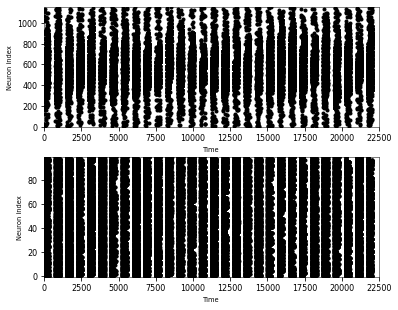

In [22]:
plot.Figure(
    plot.Panel(inp_spikes.segments[0].spiketrains,yticks=True,xticks=True,xlabel="Time"),
    plot.Panel(exc_spikes.segments[0].spiketrains,yticks=True,xticks=True,xlabel="Time")
)

In [23]:
spikes = exc_spikes.segments[0].spiketrains
# print(spikes)
spike_counts = [{i:0 for i in classes} for i in range(n_excitatory_neurons)]
for i in range(n_excitatory_neurons):
#     print(i)
    for j in list(spikes[i]):
#         print(0,i,int(j)%500)
#         print(1,i,class_history[int(j)//500])
        spike_counts[i][class_history[int(j)//time_per_exp]]+=1
labels = [0]*100
for i in range(len(spike_counts)):
    labels[i] = max(spike_counts[i], key=spike_counts[i].get)
print("Number of examples seen")
print(num_examples_seen)
print("Labels")
print(labels)
num_labels = {i:0 for i in classes}
for i in labels:
    num_labels[i]+=1
print("Number of labels")
print(num_labels)

Number of examples seen
{6: 10, 9: 10, 5: 10}
Labels
[9, 9, 9, 6, 9, 9, 5, 9, 5, 9, 9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 5, 5, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 5, 9, 9, 9, 9, 9]
Number of labels
{6: 5, 9: 85, 5: 10}


In [24]:
spike_counts

[{6: 226, 9: 355, 5: 255},
 {6: 246, 9: 353, 5: 212},
 {6: 243, 9: 287, 5: 254},
 {6: 284, 9: 283, 5: 254},
 {6: 258, 9: 321, 5: 300},
 {6: 232, 9: 374, 5: 231},
 {6: 292, 9: 304, 5: 362},
 {6: 244, 9: 298, 5: 293},
 {6: 263, 9: 292, 5: 315},
 {6: 228, 9: 264, 5: 210},
 {6: 248, 9: 342, 5: 325},
 {6: 193, 9: 320, 5: 288},
 {6: 289, 9: 354, 5: 265},
 {6: 284, 9: 355, 5: 254},
 {6: 262, 9: 289, 5: 239},
 {6: 228, 9: 285, 5: 297},
 {6: 249, 9: 364, 5: 343},
 {6: 183, 9: 338, 5: 251},
 {6: 220, 9: 353, 5: 239},
 {6: 225, 9: 338, 5: 287},
 {6: 224, 9: 309, 5: 261},
 {6: 279, 9: 290, 5: 283},
 {6: 331, 9: 317, 5: 234},
 {6: 204, 9: 273, 5: 204},
 {6: 275, 9: 366, 5: 237},
 {6: 237, 9: 338, 5: 309},
 {6: 280, 9: 336, 5: 265},
 {6: 274, 9: 321, 5: 211},
 {6: 153, 9: 290, 5: 224},
 {6: 228, 9: 368, 5: 207},
 {6: 322, 9: 280, 5: 255},
 {6: 212, 9: 320, 5: 265},
 {6: 270, 9: 347, 5: 220},
 {6: 272, 9: 319, 5: 220},
 {6: 269, 9: 273, 5: 228},
 {6: 215, 9: 315, 5: 247},
 {6: 242, 9: 325, 5: 316},
 

In [25]:
# p.reset()
p.end()

# Get Accuracy

In [26]:
# import pyNN.spiNNaker as p
# import matplotlib.pyplot as plt
# import pyNN.utility.plotting as plot
# import numpy as np
# import seaborn as sns
# import os
# import sys
# %matplotlib inline

# # Printing max length of array that can be created
# print(sys.maxsize)

# # Importing functions for NMNIST Data
# import eventvision as ev

# # Setting up simulation
# p.setup(timestep=1,time_scale_factor=5)
# # p.set_number_of_neurons_per_core(neuron_type=p.IF_cond_exp(),max_permitted=150)

# num_examples_seen = [0]*num_classes
# spike_array = [[] for _ in range(34*34)]
# for classs in class_history:
#     data_point = ev.read_dataset(os.getcwd()+"/data/train/"+str(classs)+"/"+str(training_data_lists[classs][num_examples_seen[classs]]))
#     data_point_spike_array = [[] for _ in range(34*34)]
#     for d in range(len(data_point.data.x)):
#         if data_point.data.p[d]: # Polarity = ON
#             data_point_spike_array[data_point.data.x[d]*34+data_point.data.y[d]].append(data_point.data.ts[d]//1000+time_per_exp*sum(num_examples_seen))# Plus 50 as first 50 mseconds is just to simulate start spike
#     num_examples_seen[classs]+=1
#     idx_sa = 0
#     for sa,dpsa in zip(spike_array,data_point_spike_array):
#         spike_array[idx_sa] = sa+dpsa
#         idx_sa+=1
# num_events=0
# for i in spike_array:
#     num_events+=len(i)
# print("Number of events is "+str(num_events))

# # input
# inp = p.Population(1156,
#                    p.SpikeSourceArray(spike_array),
#                    label="Input"
#                   )
# # excitatory
# exc = p.Population(n_excitatory_neurons,
#                    p.IF_cond_exp(**excitatory_neuron_parameters),
#                    initial_values={'v': excitatory_neuron_parameters["v_rest"]},
#                    label="Excitatory"
#                   )
# # inhibitory
# inh = p.Population(n_inhibitory_neurons,
#                    p.IF_cond_exp(**inhibitory_neuron_parameters),
#                    initial_values={'v': inhibitory_neuron_parameters["v_rest"]},
#                    label="Inhibitory"
#                   )

# # Record Spikes
# exc.record(["spikes"])

# max_weight = 1
# # E -> I
# # e_i_weight_rand = p.RandomDistribution(distribution='uniform',low=0.0,high=max_weight)
# p.Projection(presynaptic_population = exc,
#              postsynaptic_population = inh,
#              connector = p.OneToOneConnector(),
#              synapse_type = p.StaticSynapse(weight=1,delay=1.0),
#              receptor_type = 'excitatory'
#             )

# # I -> E
# i_e_connection_list = []
# for i in range(n_excitatory_neurons):
#     for j in range(n_inhibitory_neurons):
#         if not i==j:
#             i_e_connection_list.append((i,j))
# p.Projection(presynaptic_population = inh,
#              postsynaptic_population = exc,
#              connector = p.FromListConnector(i_e_connection_list),
#              synapse_type = p.StaticSynapse(weight=0.1,delay=1.0),
#              receptor_type = 'inhibitory'
#             )
# # Input -> E
# stdp_proj = p.Projection(presynaptic_population = inp,
#              postsynaptic_population = exc,
#              connector = p.AllToAllConnector(),
#              synapse_type = p.StaticSynapse(weight=weights,delay=1.0),
#              receptor_type = 'excitatory'
#             )

# p.run(len(class_history)*time_per_exp)

# exc_spikes = exc.get_data("spikes")